<a href="https://colab.research.google.com/github/danhph/CS2225.CH1501.Face-Mask-Detection/blob/master/WithoutFacemaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHẬN DIỆN MẶT NGƯỜI KHÔNG ĐEO KHẨU TRANG

Lớp: CS2225.CH1501  
Môn: NHẬN DẠNG THỊ GIÁC VÀ ỨNG DỤNG  
GV: PGS.TS Lê Đình Duy  
Trường ĐH Công Nghệ Thông Tin, ĐHQG-HCM  

Nhóm: 
  1. Phạm Hữu Danh - CH1901017


## 1. Các thao tác chuẩn bị

### 1.1. Giải nén dữ liệu

1. (thủ công) Download dữ liệu từ nền tảng Kaggle:
https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset/
2. (thủ công) Upload lại lển Drive cá nhân
3. Copy từ Drive vào Colab
4. Giải nén

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cp -fv /content/drive/MyDrive/Datasets/FaceMaskDataset.zip /content/FaceMaskDataset.zip
drive.flush_and_unmount()

!rm -rf /content/Face\ Mask\ Dataset
!rm -rf /content/dataset

!unzip -q /content/FaceMaskDataset.zip -d /content
!mv /content/Face\ Mask\ Dataset /content/dataset

Mounted at /content/drive
'/content/drive/MyDrive/Datasets/FaceMaskDataset.zip' -> '/content/FaceMaskDataset.zip'


### 1.2. Cài đặt các thư viện cần thiết

In [2]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime

from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
from IPython.display import HTML

!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
import face_detection

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-a98_au8h
  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-a98_au8h
  Created wheel for face-detection: filename=face_detection-0.2.1-cp36-none-any.whl size=29724 sha256=cf83bb7bf0ba66b315adec19e31320e055f28c17c7435384177b590f4e69efea
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vs4odeu/wheels/25/46/90/b08e1f7237d1e592551ee0ca37accce78ca2271f91a930c973
Successfully built face-detection


### 1.3. Hiển thị thông tin về bộ dữ liệu

In [3]:
for _name in ("Train", "Validation", "Test"):
  _total_count = len(glob(f'/content/dataset/{_name}/*/*'))
  _neg_count = len(glob(f'/content/dataset/{_name}/WithMask/*'))
  _pos_count = len(glob(f'/content/dataset/{_name}/WithoutMask/*'))
  print(f"{_name}: {_total_count} ({_neg_count} : {_pos_count})")

Train: 10000 (5000 : 5000)
Validation: 800 (400 : 400)
Test: 992 (483 : 509)


### 1.4. Thiết lập các biến constant

In [4]:
model_path = '/content/mask_classification_model.h5'

batch_size = 128

step_per_epoch = int(np.ceil(len(glob('/content/dataset/Train/*/*')) // batch_size))
validation_steps = int(np.ceil(len(glob('/content/dataset/Validation/*/*')) // batch_size))

image_h, image_w = 128, 128
num_classes = 2
classes = ['WithMask','WithoutMask']

### 1.5. Đọc các ảnh từ bộ dữ liệu

- Resize ảnh theo độ phân giải 128x 128, và scale các tensor về khoảng [-1, 1].
- Đọc 3 bộ riêng biệt: Train, Validation và Test.

In [5]:
label_map = {v:i for i, v in enumerate(classes)}

def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None, None, 3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/127.5 - 1
  return img

def load_data(image_path, label):
  image = read_img(image_path)
  return image, label

def get_images_and_labels(folder_name):
  images = glob(f'/content/dataset/{folder_name}/*/*')
  np.random.shuffle(images)
  labels = [label_map[x.split('/')[-2]] for x in images]
  return images, labels

def data_generator(features, labels):
  dataset = tf.data.Dataset.from_tensor_slices((features, labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

trn_images, trn_labels = get_images_and_labels('Train')
trn_dataset = data_generator(trn_images, trn_labels)

val_images, val_labels = get_images_and_labels('Validation')
val_dataset = data_generator(val_images, val_labels)

tst_images, tst_labels = get_images_and_labels('Test')

### 1.6. Hiển thị một số ảnh minh họa

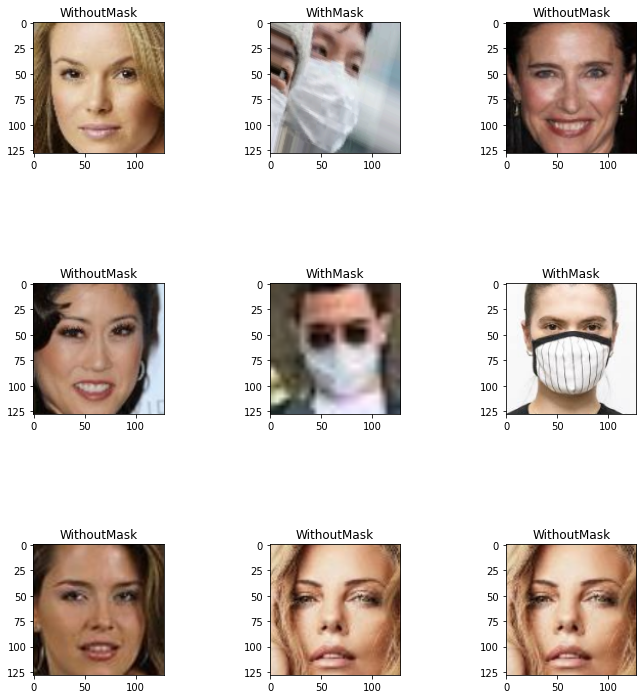

In [6]:
def show_img(dataset):
  plt.figure(figsize=(12, 12))
  for i in range(9):
    for val in dataset.take(1):
      img  = (val[0][i] + 1)*127.5
      plt.subplot(3, 3, i + 1)
      plt.imshow(tf.cast(img, tf.uint8))
      plt.title(classes[val[1][i].numpy()])
      plt.subplots_adjust(hspace=1)
  plt.show()

show_img(trn_dataset)

# 2. Xây dựng mô hình

Face Mask Detection = Face Mask Classification + Face Detection

Tách thành 2 bài toán nhỏ hơn là:  
- Bài toán 1: Nhận diện khuôn mặt   
- Bài toán 2: Phân loại khuôn mặt không đeo khẩu trang  


## 2.1. Xây dựng bài toán 2: Face Mask Classification

Sử dụng phương pháp Transfer Learning với mô hình Xception (đã huấn luyện trên ImageNet).

In [7]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_____________________________

### 2.1.1. Thiết lập các tham số và huấn luyện mô hình

In [8]:
epochs = 5

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        save_best_only=True,
        monitor='loss')
]

history = model.fit(trn_dataset,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=step_per_epoch,
          validation_data=val_dataset,
          validation_steps=validation_steps,
          validation_batch_size=batch_size,
          callbacks=callbacks)

Epoch 1/5
78/78 [==============================] - 23s 173ms/step - loss: 0.1220 - accuracy: 0.9446 - val_loss: 0.0202 - val_accuracy: 0.9987
Epoch 2/5
78/78 [==============================] - 13s 165ms/step - loss: 0.0154 - accuracy: 0.9960 - val_loss: 0.0223 - val_accuracy: 0.9948
Epoch 3/5
78/78 [==============================] - 13s 165ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0186 - val_accuracy: 0.9987
Epoch 4/5
78/78 [==============================] - 13s 169ms/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.0147 - val_accuracy: 0.9987
Epoch 5/5
78/78 [==============================] - 13s 173ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.0102 - val_accuracy: 0.9987


### 2.1.2. Hiển thị một số kết quả ngẫu nhiên

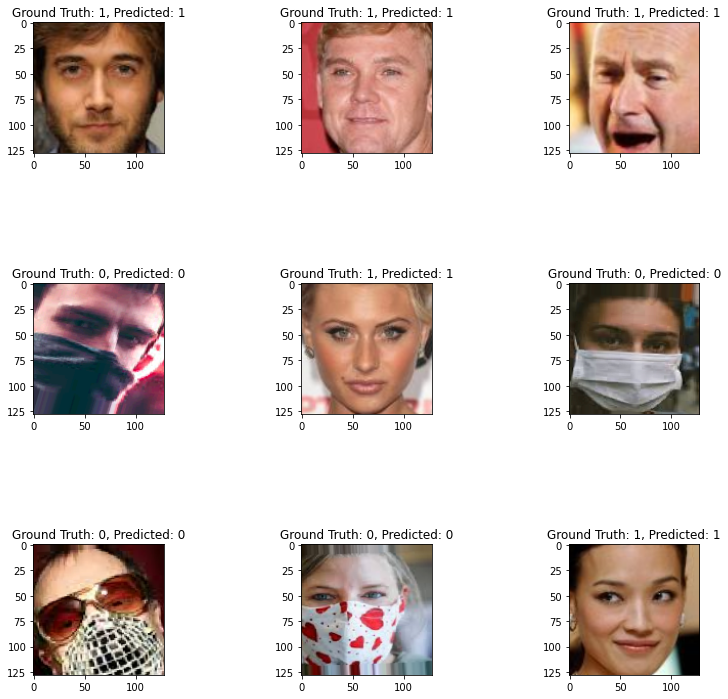

In [9]:
plt.figure(figsize=(12, 12))
for i in range(9):
  for val in trn_dataset.take(1):
    plt.subplot(3, 3, i + 1)
    img  = (val[0][i] + 1)*127.5
    plt.imshow(tf.cast(img, tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i], axis=0))
    y_pred = np.argmax(y_pred, axis=1)
    plt.title('Ground Truth: {}, Predicted: {}'.format(val[1][i], y_pred[0]))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

### 2.1.3. Đánh giá mô hình

In [10]:
prd_labels = []
for image_path in (tst_images):
  image = read_img(image_path)
  y_pred = model.predict(np.expand_dims(image,axis=0))
  y_pred = np.argmax(y_pred,axis=1)
  prd_labels.append(y_pred)

print(classification_report(tst_labels, prd_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       483
           1       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



## 2.2. Xây dựng bài toán 1: Face Detection:

Sử dụng mô hình RetinaFace

In [11]:
image_max_res = 1024

def resize_image(img):
  height, width = img.shape[:2]
  if height > image_max_res or width > image_max_res:
    scaling_factor = min(image_max_res/height, image_max_res/width)
    img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
  return img

print(face_detection.available_detectors)

face_detector = face_detection.build_detector(
  "RetinaNetResNet50", 
  max_resolution=image_max_res)

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_ResNet50.pth" to /root/.cache/torch/hub/checkpoints/RetinaFace_ResNet50.pth


## 2.3. Thử nghiệm mô hình

### 2.3.1. Tải một số ảnh chọn lọc từ Unsplash

In [13]:
!rm -rf /content/assets
!mkdir /content/assets

!wget -q -O /content/assets/image1.jpg https://unsplash.com/photos/1d_nqtAnpLM/download?force=true&w=1920
!wget -q -O /content/assets/image2.jpg https://unsplash.com/photos/4yXV0JIK-yo/download?force=true&w=1920
!wget -q -O /content/assets/image3.jpg https://unsplash.com/photos/Gq9L5zS1uQ8/download?force=true&w=1920
!wget -q -O /content/assets/image4.jpg https://unsplash.com/photos/sRC0i_GwhRc/download?force=true&w=1920

### 2.3.2. Các hàm hiển thị

In [14]:
color_box_map = {
  0: [0, 1, 0],
  1: [1, 0, 0]
}

model = tf.keras.models.load_model(model_path)

def visualize_detections(image, boxes):
  figsize = (12, 12)
  linewidth = 1
  
  image = np.array(image, dtype=np.uint8)
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)
  ax = plt.gca()

  for box in boxes:
    left, bottom, right, top = box
    bottom = int(np.round(bottom))
    top = int(np.round(top))
    left = int(np.round(left))
    right = int(np.round(right))

    face_image = image[bottom:top, left:right]
    if not face_image.shape[0] or not face_image.shape[1]:
      continue

    face_image = tf.image.resize(face_image, [image_w, image_h])
    face_image = face_image / 127.5 - 1
    label = model.predict(np.expand_dims(face_image, axis=0))
    label = np.argmax(label, axis=1)[0]

    patch = plt.Rectangle(
        (left, bottom), right-left, top-bottom, 
        fill=False,
        edgecolor=color_box_map[label], 
        linewidth=linewidth)
    ax.add_patch(patch)

def visualize_detections_video(image, boxes):
  linewidth = 1

  image = np.array(image, dtype=np.uint8)
  for box in boxes:
    left, bottom, right, top = box
    bottom = int(np.round(bottom))
    top = int(np.round(top))
    left = int(np.round(left))
    right = int(np.round(right))

    face_image = image[bottom:top, left:right]
    if not face_image.shape[0] or not face_image.shape[1]:
      continue

    face_image = tf.image.resize(face_image, [image_w, image_h])
    face_image = face_image / 127.5 - 1
    label = model.predict(np.expand_dims(face_image, axis=0))
    label = np.argmax(label, axis=1)[0]

    cv2.rectangle(image, (left, bottom), (right, top), color_map_video[label], linewidth)
  return image

### 2.3.3. Thử nghiệm với hình ảnh đã tải

/content/assets/image4.jpg: 0:00:01.336979
/content/assets/image3.jpg: 0:00:01.514440
/content/assets/image2.jpg: 0:00:01.787204
/content/assets/image1.jpg: 0:00:01.075248


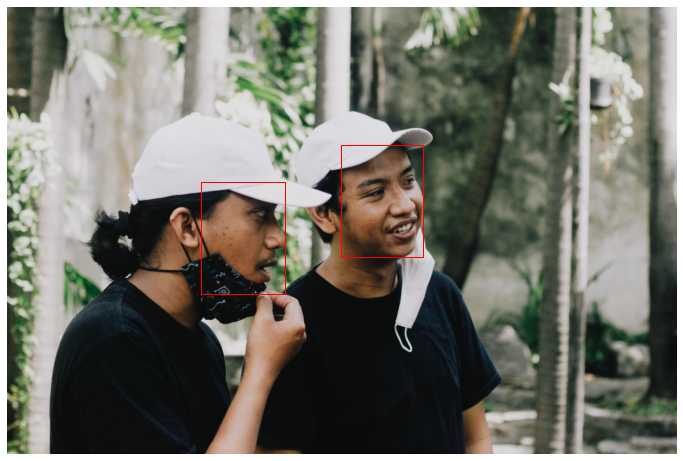

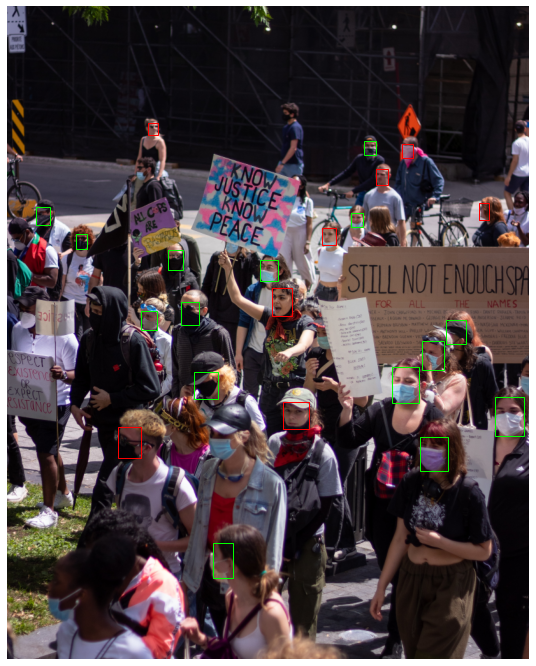

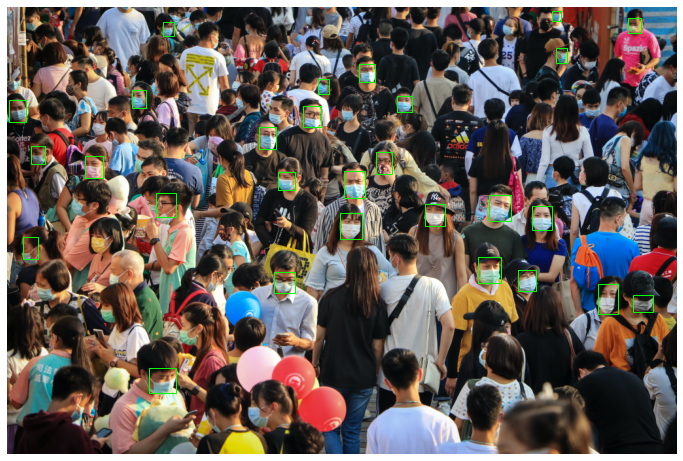

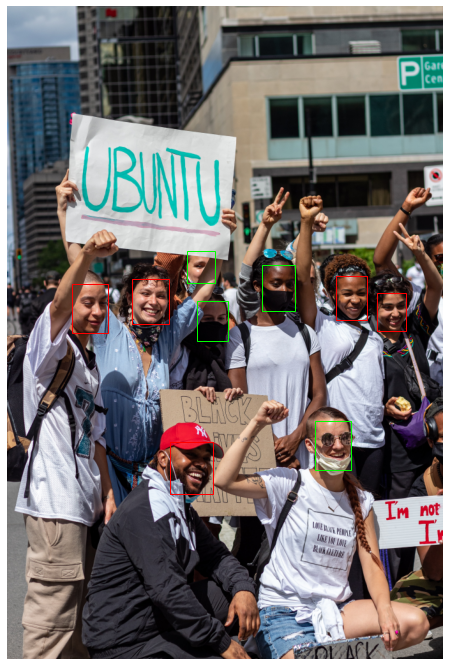

In [15]:
for image_path in glob('/content/assets/*.jpg'):
  start = datetime.now()
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)
  end = datetime.now()

  print(f"{image_path}: {end - start}")

### 2.3.4. Thử nghiệm với ảnh chụp trực tiếp từ Webcam

In [16]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Ảnh Webcam không đeo khẩu trang

<IPython.core.display.Javascript object>

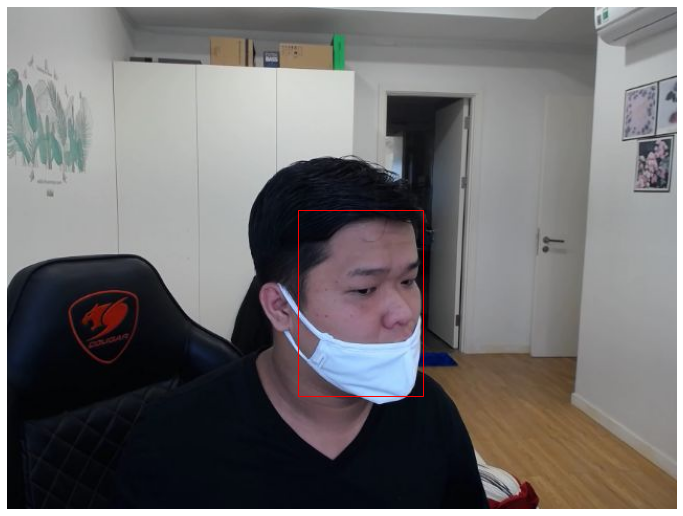

In [22]:
try:
  image_path = take_photo("selfie_without_facemask.jpg")

  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)

except Exception as err:
  print(str(err))

Ảnh Webcam có đeo khẩu trang

<IPython.core.display.Javascript object>

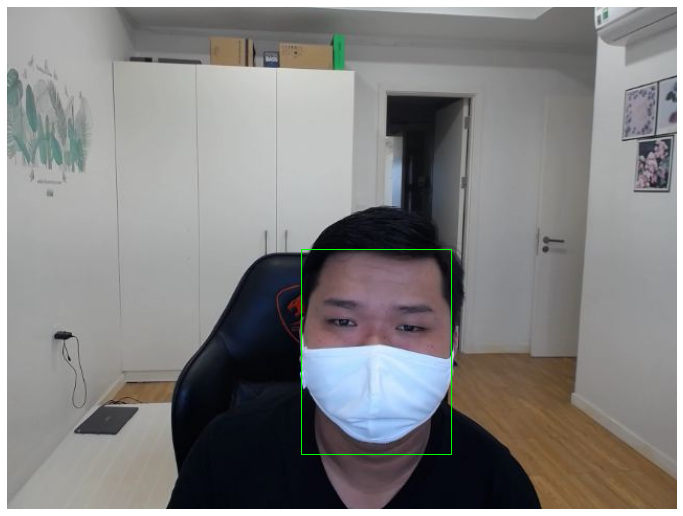

In [21]:
try:
  image_path = take_photo("selfie_with_facemask.jpg")
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
  image = resize_image(image) 
  boxes = face_detector.detect(image[:, :, ::-1])[:, :4]
  labels = visualize_detections(image, boxes)
except Exception as err:
  print(str(err))